In [21]:
import pickle
import pandas as pd

with open("data/cascade_comparison_records.pkl", "rb") as file:
    ALL_RECORDS = pickle.load(file)

DATA = ALL_RECORDS
df = pd.DataFrame(DATA)
df['cascade_symbol'] = [ "->".join([str(y) for y in x]) for x in df['cascade']]

In [23]:
import numpy as np

def compute_minmax(data_cts, data_grid):
    overall_min = max(
        np.min([ x[0] for x in data_cts ]),
        np.min([ x[0] for x in data_grid ])
    )
    overall_max = min(
        np.max([ x[0] for x in data_grid ]), 
        np.max([ x[0] for x in data_cts ])
    )
    return overall_max-overall_min

for i in range(int(len(df)/2)):
    assert df.loc[2*i, 'method'] == 'continuous_optimization'
    assert df.loc[2*i+1, 'method'] == 'gridsearch'
    assert df.loc[2*i, 'benchmark'] == df.loc[2*i+1, 'benchmark']
    assert df.loc[2*i, 'cascade_symbol'] == df.loc[2*i+1, 'cascade_symbol']
    cts_data = df.loc[2*i, 'data'] 
    grid_data = df.loc[2*i + 1, 'data']
    
    df.loc[2*i, 'auc_norm'] = compute_minmax(cts_data, grid_data)
    df.loc[2*i+1, 'auc_norm'] = compute_minmax(cts_data, grid_data)

df['auc'] = 1 - df['performance']/df['auc_norm']

In [56]:
from scipy import stats

### WILCOXON TESTS BY CASCADE LEN

def run_paired_wilcoxon_tests_by_len(df):
    results = []
    
    # For each cascade length
    for cascade_len in df['cascade_len'].unique():
        # Get all data for this cascade length
        mask = (df['cascade_len'] == cascade_len)
        data = df[mask]
        
        # Create paired samples using benchmark and cascade_symbol
        continuous = data[data['method'] == 'continuous_optimization'].set_index(['benchmark', 'cascade_symbol'])['auc']
        gridsearch = data[data['method'] == 'gridsearch'].set_index(['benchmark', 'cascade_symbol'])['auc']
        
        # Make sure we have the same pairs in both
        common_pairs = continuous.index.intersection(gridsearch.index)
        continuous = continuous[common_pairs]
        gridsearch = gridsearch[common_pairs]
        
        # Run test if we have data
        if len(continuous) > 0 and len(gridsearch) > 0:
            stat, pval = stats.wilcoxon(gridsearch, continuous, alternative='greater')
            results.append({
                'cascade_len': cascade_len,
                'n_pairs': len(continuous),
                'statistic': stat,
                'pvalue': pval
            })
    
    return pd.DataFrame(results)

run_paired_wilcoxon_tests_by_len(df)

,cascade_len,n_pairs,statistic,pvalue
0,2,60,766.0,8.636528e-01
1,3,60,1753.0,3.435655e-10
2,4,30,394.0,2.527442e-04
3,5,6,18.0,7.812500e-02


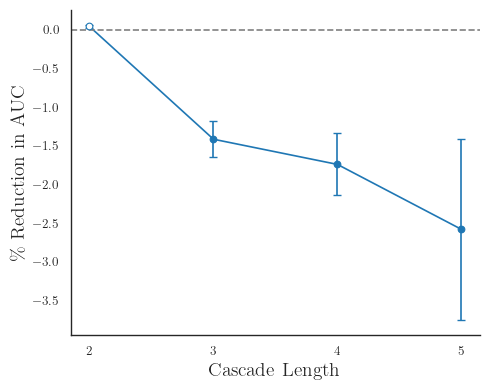

In [55]:
### Plot reduction in AUC by cascade length

def compute_reduction_stats(df, cascade_len):
    continuous = df[(df['method'] == 'continuous_optimization') & (df['cascade_len'] == cascade_len)]['auc']
    gridsearch = df[(df['method'] == 'gridsearch') & (df['cascade_len'] == cascade_len)]['auc']
    
    pct_changes = 100 * (continuous.values - gridsearch.values) / gridsearch.values
    n = len(pct_changes)
    return np.mean(pct_changes), np.std(pct_changes, ddof=1)/np.sqrt(n)

cascade_lengths = sorted(df['cascade_len'].unique())
means = []
sems = []
for length in cascade_lengths:
    mean, sem = compute_reduction_stats(df, length)
    means.append(mean)
    sems.append(sem)

# Plot line first
ax.plot(cascade_lengths, means, '-')

# Then plot points with different fills
for i, (x, y, sem) in enumerate(zip(cascade_lengths, means, sems)):
    if i == 0:  # first point (not significant)
        ax.scatter(x, y, color='white', edgecolor='tab:blue', zorder=3)
    else:  # other points
        ax.scatter(x, y, color='tab:blue', zorder=3)

# Add error bars
ax.errorbar(cascade_lengths, means, yerr=sems, fmt='none', capsize=3, color='tab:blue')

ax.axhline(y=0, linestyle='dashed', color='gray')
ax.set_xlabel("Cascade Length", fontsize=14)
ax.set_ylabel("\\% Reduction in AUC", fontsize=14)
# ax.set_title("\% Reduction in AUC using Continuous Optimization")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()

ax.set_xticks([2,3,4,5])

In [50]:
### PAIRED WILCOXON TEST BY BENCHMARK

def analyze_auc_by_benchmark(df):
   results = []
   
   for benchmark in df['benchmark'].unique():
       # Get all data for this benchmark
       data = df[df['benchmark'] == benchmark]
       
       # Get AUC for each method
       continuous = data[data['method'] == 'continuous_optimization'].set_index(['cascade_len', 'cascade_symbol'])['auc']
       gridsearch = data[data['method'] == 'gridsearch'].set_index(['cascade_len', 'cascade_symbol'])['auc']
       
       # Make sure we have the same cases
       common_pairs = continuous.index.intersection(gridsearch.index)
       continuous = continuous[common_pairs]
       gridsearch = gridsearch[common_pairs]
       
       # Compute percentage differences
       percent_diffs = 100 * (continuous - gridsearch) / gridsearch
       
       # Conduct Wilcoxon test
       stat, pval = stats.wilcoxon(gridsearch, continuous, alternative='greater')
       
       results.append({
           'benchmark': benchmark,
           'mean_percent_change': percent_diffs.mean(),
           'continuous_auc': continuous.mean(),
           'grid_auc': gridsearch.mean(),
           'n_pairs': len(continuous),
           'wilcoxon_stat': stat,
           'p_value': pval
       })
   
   return pd.DataFrame(results)

# Create and display results
results = analyze_auc_by_benchmark(df)
print(results)

    benchmark  mean_percent_change  continuous_auc  grid_auc  n_pairs  \
0       gsm8k            -2.482323        0.158981  0.162773       26   
1  truthfulqa            -0.288101        0.436522  0.437833       26   
2    triviaqa            -0.704696        0.181979  0.183110       26   
3        xsum            -1.485427        0.408479  0.413596       26   
4     medmcqa            -0.776327        0.381067  0.383697       26   
5        mmlu            -0.000925        0.288021  0.288061       26   

   wilcoxon_stat       p_value  
0          302.0  3.727227e-04  
1          262.0  1.359791e-02  
2          270.0  7.566065e-03  
3          340.0  8.195639e-07  
4          276.0  4.691273e-03  
5          197.0  2.997737e-01  


In [366]:
df.groupby(by=['method', 'cascade_len'])['time'].mean()

method                   cascade_len
continuous_optimization  2                0.268455
                         3                3.725994
                         4               12.207035
                         5               22.617215
gridsearch               2                0.008467
                         3                0.331233
                         4               14.638867
                         5              663.020116
Name: time, dtype: float64

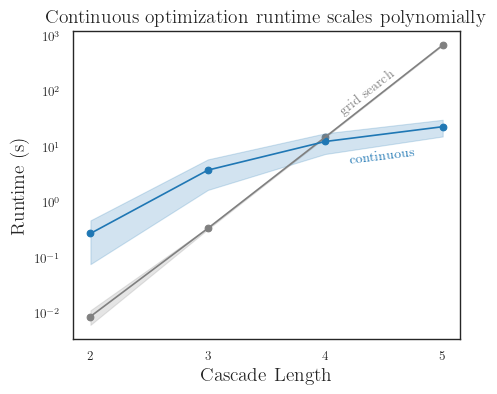

In [379]:
### Plot runtime comparison

# Set seaborn style first
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)

# Then matplotlib settings
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['font.size'] = 10

runtime_by_method = df.groupby(by=['method', 'cascade_len'])['time'].mean()

fig, ax = plt.subplots(figsize=(5,4))

cascade_lens = [2,3,4,5]

color_grid = 'gray'
color_cts = 'tab:blue'
ax.scatter(cascade_lens, runtime_by_method.loc['gridsearch'], color=color_grid)
ax.plot(cascade_lens, runtime_by_method.loc['gridsearch'], color=color_grid)

ax.fill_between(cascade_lens, 
                runtime_by_method.loc['gridsearch'] - df.groupby(by=['method', 'cascade_len'])['time'].std().loc['gridsearch'],  # Lower bound
                runtime_by_method.loc['gridsearch'] + df.groupby(by=['method', 'cascade_len'])['time'].std().loc['gridsearch'],  # Upper bound
                color=color_grid, 
                alpha=0.2,  # Transparency
                label='±1 std')

ax.text(4.1, 38, "grid search", color=color_grid, fontweight='bold').set_rotation(38)
ax.scatter(cascade_lens, runtime_by_method.loc['continuous_optimization'], color=color_cts)
ax.plot(cascade_lens, runtime_by_method.loc['continuous_optimization'], color=color_cts)
ax.text(4.2, 5, "continuous", color=color_cts, fontweight='bold').set_rotation(7)

ax.fill_between(cascade_lens, 
                runtime_by_method.loc['continuous_optimization'] - df.groupby(by=['method', 'cascade_len'])['time'].std().loc['continuous_optimization'],  # Lower bound
                runtime_by_method.loc['continuous_optimization'] + df.groupby(by=['method', 'cascade_len'])['time'].std().loc['continuous_optimization'],  # Upper bound
                color=color_cts, 
                alpha=0.2,  # Transparency
                label='±1 std')

ax.set_xlabel("Cascade Length", fontsize=14)
ax.set_xticks(cascade_lens)
ax.set_xticklabels(cascade_lens)
ax.set_ylabel("Runtime (s)", fontsize=14)

ax.set_yscale('log')